<a href="https://colab.research.google.com/github/sebasrosalesr/Sample-projects/blob/main/SkimLit_NLP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##PubMed 200k RCT: a Dataset for Sequential Sentence Classification in Medical Abstracts

Franck Dernoncourt, Ji Young Lee

We present PubMed 200k RCT, a new dataset based on PubMed for sequential sentence classification. The dataset consists of approximately 200,000 abstracts of randomized controlled trials, totaling 2.3 million sentences. Each sentence of each abstract is labeled with their role in the abstract using one of the following classes: background, objective, method, result, or conclusion. The purpose of releasing this dataset is twofold. First, the majority of datasets for sequential short-text classification (i.e., classification of short texts that appear in sequences) are small: we hope that releasing a new large dataset will help develop more accurate algorithms for this task. Second, from an application perspective, researchers need better tools to efficiently skim through the literature. Automatically classifying each sentence in an abstract would help researchers read abstracts more efficiently, especially in fields where abstracts may be long, such as the medical field.

In [ ]:
!git clone https://github.com/Franck-Dernoncourt/pubmed-rct

Cloning into 'pubmed-rct'...
remote: Enumerating objects: 39, done.
remote: Counting objects: 100% (14/14), done.
remote: Compressing objects: 100% (9/9), done.
remote: Total 39 (delta 8), reused 5 (delta 5), pack-reused 25
Receiving objects: 100% (39/39), 177.08 MiB | 16.25 MiB/s, done.
Resolving deltas: 100% (15/15), done.


In [ ]:
!ls pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign

dev.txt  test.txt  train.txt


In [ ]:
#Start experiments with the 20k data set
data_dir = "/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/"

In [ ]:
#check all the files in the data dir
import os
filenames = [data_dir + filenames for filenames in os.listdir(data_dir)]
filenames

['/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/dev.txt',
 '/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/test.txt',
 '/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/train.txt']

## Preprocess data


In [ ]:
#create a function to read the files on a document
def read_data(filename):
  with open(filename, 'r') as f:
    data = f.readlines()
  return data

In [ ]:
train_lines = read_data(data_dir+'train.txt')
train_lines[:10]

['###24293578\n',
 'OBJECTIVE\tTo investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( OA ) .\n',
 'METHODS\tA total of @ patients with primary knee OA were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .\n',
 'METHODS\tOutcome measures included pain reduction and improvement in function scores and systemic inflammation markers .\n',
 'METHODS\tPain was assessed using the visual analog pain scale ( @-@ mm ) .\n',
 'METHODS\tSecondary outcome measures included the Western Ontario and McMaster Universities Osteoarthritis Index scores , patient global assessment ( PGA ) of the severity of knee OA , and @-min walk distance ( @MWD ) .\n',
 'METHODS\tSerum levels of interleukin @ ( IL-@ ) , IL-@ , tumor necrosis factor ( TNF ) - , and 

In [ ]:
len(train_lines)

210040

Create a dictionary to preprocess the texts:

    {
        "line_number": 0,
        "target": "BACKGROUND",
        "text": "Emotional eating is associated with overeating and the development of obesity.\n",
        "total_lines": 11
    },
    ...
]

In [ ]:
def preprocess_data(filename):
    input_lines = read_data(filename)
    abstract_lines = ""
    abstract_samples = []

    for line in input_lines:
        if line.startswith("###"):
            abstract_id = line
            abstract_lines = ""
        elif line.isspace():
            abstract_line_split = abstract_lines.splitlines()

            # Iterate through each line in a single abstract and count them at the same time
            for abstract_line_number, abstract_line in enumerate(abstract_line_split):
                line_data = {}  # create an empty dictionary for each line
                target_text_split = abstract_line.split("\t")  # split target label from text
                line_data["target"] = target_text_split[0]  # get target label
                line_data["text"] = target_text_split[1].lower()  # get target text and lower it
                line_data["line_number"] = abstract_line_number  # what number line does the line appear in the abstract
                line_data["total_lines"] = len(abstract_line_split) - 1  # how many total lines are there in the target abstract? (start counting from 0)
                abstract_samples.append(line_data)  # add line data to abstract samples list

        else:  # if the above conditions aren't fulfilled, the line contains a labeled sentence
            abstract_lines += line

    return abstract_samples


In [ ]:
#get data file and process it
%%time
train_samples = preprocess_data(data_dir+'train.txt')
val_samples = preprocess_data(data_dir+'dev.txt')
test_samples = preprocess_data(data_dir+'test.txt')
print(len(train_samples))
print(len(val_samples))
print(len(test_samples))

180040
30212
30135
CPU times: user 323 ms, sys: 68.5 ms, total: 392 ms
Wall time: 391 ms


In [ ]:
#check the first 10 from the train samples dictionary
train_samples[10:20]

[{'target': 'RESULTS',
  'text': 'the outcome measures in rheumatology clinical trials-osteoarthritis research society international responder rate was @ % in the intervention group and @ % in the placebo group ( p < @ ) .',
  'line_number': 10,
  'total_lines': 11},
 {'target': 'CONCLUSIONS',
  'text': 'low-dose oral prednisolone had both a short-term and a longer sustained effect resulting in less knee pain , better physical function , and attenuation of systemic inflammation in older patients with knee oa ( clinicaltrials.gov identifier nct@ ) .',
  'line_number': 11,
  'total_lines': 11},
 {'target': 'BACKGROUND',
  'text': 'emotional eating is associated with overeating and the development of obesity .',
  'line_number': 0,
  'total_lines': 10},
 {'target': 'BACKGROUND',
  'text': 'yet , empirical evidence for individual ( trait ) differences in emotional eating and cognitive mechanisms that contribute to eating during sad mood remain equivocal .',
  'line_number': 1,
  'total_lin

In [ ]:
import pandas as pd

train_df = pd.DataFrame(train_samples)
val_df = pd.DataFrame(val_samples)
test_df = pd.DataFrame(test_samples)

In [ ]:
train_df.head(15)

,target,text,line_number,total_lines
0,OBJECTIVE,to investigate the efficacy of @ weeks of dail...,0,11
1,METHODS,a total of @ patients with primary knee oa wer...,1,11
2,METHODS,outcome measures included pain reduction and i...,2,11
3,METHODS,pain was assessed using the visual analog pain...,3,11
4,METHODS,secondary outcome measures included the wester...,4,11
5,METHODS,"serum levels of interleukin @ ( il-@ ) , il-@ ...",5,11
6,RESULTS,there was a clinically relevant reduction in t...,6,11
7,RESULTS,the mean difference between treatment arms ( @...,7,11
8,RESULTS,"further , there was a clinically relevant redu...",8,11
9,RESULTS,these differences remained significant at @ we...,9,11


In [ ]:
train_df.target.value_counts()

target
METHODS        59353
RESULTS        57953
CONCLUSIONS    27168
BACKGROUND     21727
OBJECTIVE      13839
Name: count, dtype: int64

<Axes: ylabel='Frequency'>

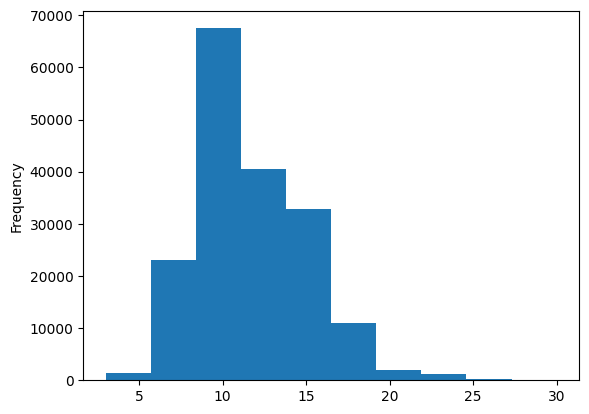

In [ ]:
train_df.total_lines.plot.hist()

## Get the list of the sentences

In [ ]:
train_sentences = train_df.text.tolist()
val_sentences = val_df.text.tolist()
test_sentences = test_df.text.tolist()

len(train_sentences), len(val_sentences), len(test_sentences)

(180040, 30212, 30135)

In [ ]:
train_sentences[:10]

['to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
 'secondary outcome measures included the western ontario and mcmaster universities osteoarthritis index scores , patient global assessment ( pga ) of the severity of knee oa , and @-min walk distance ( @mwd ) .',
 'serum levels of interleukin @ ( il-@ ) , il-@ , tumor necrosis factor ( tnf ) - , and high-sensitivity c-reactive protein ( hscrp ) were measured .',
 'there was a clinic

## Make it numeric labels (Mls model)

In [ ]:
#One hot enconde the labels
from sklearn.preprocessing import OneHotEncoder

onehot_encoder = OneHotEncoder(sparse_output=False)
train_labels_onehot = onehot_encoder.fit_transform(train_df.target.values.reshape(-1, 1))
val_labels_onehot = onehot_encoder.transform(val_df.target.values.reshape(-1, 1))
test_labels_onehot = onehot_encoder.transform(test_df.target.values.reshape(-1, 1))

In [ ]:
train_labels_onehot

array([[0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       ...,
       [0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.]])

In [ ]:
import tensorflow as tf
tf.constant(train_labels_onehot)

<tf.Tensor: shape=(180040, 5), dtype=float64, numpy=
array([[0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       ...,
       [0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.]])>

In [ ]:
#Extract labels
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
train_labels_encoded = label_encoder.fit_transform(train_df.target.values)
val_labels_encoded = label_encoder.transform(val_df.target.values)
test_labels_encoded = label_encoder.transform(test_df.target.values)

In [ ]:
#Get the classes
num_classes = len(label_encoder.classes_)
class_names = label_encoder.classes_
num_classes, class_names

(5,
 array(['BACKGROUND', 'CONCLUSIONS', 'METHODS', 'OBJECTIVE', 'RESULTS'],
       dtype=object))

## Get the baseline model


In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report

# Create a pipeline with
model_0 = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('clf', MultinomialNB())
])

# Train the model
model_0.fit(train_sentences, train_labels_encoded)

Pipeline(steps=[('tfidf', TfidfVectorizer()), ('clf', MultinomialNB())])

In [ ]:
#evaluate the basemodel
baseline_score = model_0.score(val_sentences, val_labels_encoded)
print(f"Our baseline model achieves an accuracy of: {baseline_score*100:.2f}%")

Our baseline model achieves an accuracy of: 72.18%


In [ ]:
baseline_preds = model_0.predict(val_sentences)
baseline_preds[:20]

array([4, 1, 3, 2, 2, 2, 2, 2, 4, 4, 0, 4, 1, 1, 2, 2, 4, 1, 4, 4])

In [ ]:
#Get the helper function
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

--2024-08-06 17:27:04--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.111.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0.001s  

2024-08-06 17:27:05 (9.01 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [ ]:
from helper_functions import calculate_results

In [ ]:
base_line_results = calculate_results(y_true=val_labels_encoded,
                                     y_pred=baseline_preds)
base_line_results

{'accuracy': 72.1832384482987,
 'precision': 0.7186466952323352,
 'recall': 0.7218323844829869,
 'f1': 0.6989250353450294}

## Preparing our data (the text) for deep sequence models
Before we start building deeper models, we've got to create vectorization and embedding layers.

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers

#how long is each sentence on average
avg_length = round(sum([len(sentence.split()) for sentence in train_sentences])/len(train_sentences))
avg_length

26

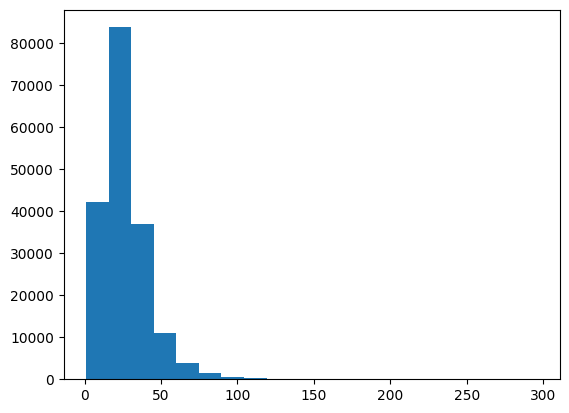

In [ ]:
import matplotlib.pyplot as plt
plt.hist([len(sentence.split()) for sentence in train_sentences], bins=20);

In [ ]:
# percentile
output_sequence_length = int(np.percentile([len(sentence.split()) for sentence in train_sentences], 95))
output_sequence_length

55

## Create a text vectorizer


In [ ]:
max_tokens = 68000

In [ ]:
from keras.layers import TextVectorization

In [ ]:
text_vectorizer = TextVectorization(max_tokens=max_tokens,
                                    output_sequence_length = output_sequence_length)

In [ ]:
text_vectorizer.adapt(train_sentences)


In [ ]:
#test out the text vectorizer on random sentences
import random
random_sentence = random.choice(train_sentences)
print(f"Original text:\n{random_sentence}\
      \n\nVectorized version:")
print(f'{text_vectorizer(random_sentence)}')
print(f'Lenght of the sentence: {len(random_sentence.split())}')

Original text:
subendocardial strain analysis is currently feasible in two-dimensional and three-dimensional ( @d ) echocardiography ; however , there is a lack of clarity regarding the most useful strain component for subclinical disease detection .      

Vectorized version:
[15393  1679    85    20  1325  1099     5  8341     3  4925   187  2125
   140    61    20     8  1207     4  8498   539     2   215   998  1679
  1225    11  4351   114   989     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0]
Lenght of the sentence: 34


In [ ]:
# How many words in our training vocabulary
rct_20k_text_vocab = text_vectorizer.get_vocabulary()

print(f"Number of words in vocab: {len(rct_20k_text_vocab)}")
print(f"Most common words in the vocab: {rct_20k_text_vocab[:5]}")
print(f"Least common words in the vocab: {rct_20k_text_vocab[-5:]}")


Number of words in vocab: 64841
Most common words in the vocab: ['', '[UNK]', 'the', 'and', 'of']
Least common words in the vocab: ['aainduced', 'aaigroup', 'aachener', 'aachen', 'aaacp']


In [ ]:
text_vectorizer.get_config()

{'name': 'text_vectorization',
 'trainable': True,
 'dtype': {'module': 'keras',
  'class_name': 'DTypePolicy',
  'config': {'name': 'float32'},
  'registered_name': None},
 'max_tokens': 68000,
 'standardize': 'lower_and_strip_punctuation',
 'split': 'whitespace',
 'ngrams': None,
 'output_mode': 'int',
 'output_sequence_length': 55,
 'pad_to_max_tokens': False,
 'sparse': False,
 'ragged': False,
 'vocabulary': None,
 'idf_weights': None,
 'encoding': 'utf-8',
 'vocabulary_size': 64841}

## Create a custom text embedding

In [ ]:
#Create a token embedding layer
token_embedding = layers.Embedding(input_dim=max_tokens,
                                 output_dim=128,
                                 mask_zero=True,
                                 name='token_embedding')

## Creating datasets (making sure our data loads as fast as possible)

We're going to setup our data to run as fast as possible with the TensorFlow `tf.data` API. Many of the steps here are discussed at length in these two resources:
* [https://www.tensorflow.org/guide/data_performance](https://www.tensorflow.org/guide/data_performance)

In [ ]:
#transform the data into tensorflow data set
train_dataset = tf.data.Dataset.from_tensor_slices((tf.constant(train_sentences), train_labels_encoded))
valid_dataset = tf.data.Dataset.from_tensor_slices((tf.constant(val_sentences), val_labels_encoded))
test_dataset = tf.data.Dataset.from_tensor_slices((tf.constant(test_sentences), test_labels_encoded))

In [ ]:
train_dataset

<_TensorSliceDataset element_spec=(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>

In [ ]:
train_dataset = train_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
valid_dataset = valid_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

## MODEL_1 Conv1D

In [ ]:
inputs = layers.Input(shape=(1,), dtype=tf.string)
x = text_vectorizer(inputs)
x = token_embedding(x)
x = layers.Conv1D(64, kernel_size=5, padding= 'same', activation='relu')(x)
x = layers.GlobalAveragePooling1D()(x)
outputs = layers.Dense(num_classes, activation='softmax')(x)
model_1 = tf.keras.Model(inputs, outputs, name='model_1_conv1d')

/usr/local/lib/python3.10/dist-packages/keras/src/layers/layer.py:915: UserWarning: Layer 'conv1d' (of type Conv1D) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


In [ ]:
#Compile the model
model_1.compile(loss='sparse_categorical_crossentropy',
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['accuracy'])

In [ ]:
model_1.summary()

Model: "model_1_conv1d"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 1)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ text_vectorization                   │ (None, 55)                  │               0 │
│ (TextVectorization)                  │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ token_embedding (Embedding)          │ (None, 55, 128)             │       8,704,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d (Conv1D)                      │ (None, 55, 64)              │          41,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling1d             │ (None, 64)                  │               0 │
│ (GlobalAveragePooling1D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 5)                   │             325 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 8,745,349 (33.36 MB)

 Trainable params: 8,745,349 (33.36 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# fit the model
hisory_1 = model_1.fit(train_dataset,
                        steps_per_epoch=int(0.1*len(train_dataset)),
                        epochs=3,
                        validation_data=valid_dataset,
                        validation_steps=int(0.1*len(valid_dataset)))

Epoch 1/3
562/562 ━━━━━━━━━━━━━━━━━━━━ 24s 41ms/step - accuracy: 0.5171 - loss: 1.1693 - val_accuracy: 0.7384 - val_loss: 0.6976
Epoch 2/3
562/562 ━━━━━━━━━━━━━━━━━━━━ 21s 38ms/step - accuracy: 0.7450 - loss: 0.6890 - val_accuracy: 0.7686 - val_loss: 0.6345
Epoch 3/3
562/562 ━━━━━━━━━━━━━━━━━━━━ 20s 36ms/step - accuracy: 0.7691 - loss: 0.6240 - val_accuracy: 0.7892 - val_loss: 0.5885


In [ ]:
model_1.evaluate(test_dataset)

942/942 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.7809 - loss: 0.6109


[0.6111011505126953, 0.782677948474884]

In [ ]:
model_1_pred_probs = model_1.predict(test_dataset)

942/942 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step


In [ ]:
model_1_pred_probs[:10]

array([[3.5878953e-01, 6.1978657e-02, 2.2498628e-01, 3.2527411e-01,
        2.8971361e-02],
       [2.2623343e-03, 1.5226374e-03, 9.4913787e-01, 3.3174243e-03,
        4.3759771e-02],
       [4.7589239e-04, 3.0570691e-03, 8.1402516e-01, 2.7426999e-04,
        1.8216749e-01],
       [6.1636110e-04, 7.0058898e-04, 9.2732549e-01, 1.3986528e-03,
        6.9958940e-02],
       [1.6583379e-03, 4.3064162e-02, 1.3282445e-02, 1.0174311e-03,
        9.4097763e-01],
       [1.3648052e-08, 2.8909812e-05, 1.7660141e-06, 7.0639512e-09,
        9.9996918e-01],
       [5.5917126e-06, 6.6288549e-04, 1.5137278e-03, 2.2932109e-06,
        9.9781549e-01],
       [5.9984410e-01, 1.5825601e-01, 5.8759330e-03, 2.3482023e-01,
        1.2037278e-03],
       [2.7768821e-01, 4.6803153e-01, 3.1716760e-02, 1.6774306e-01,
        5.4820489e-02],
       [3.2218412e-01, 4.3154079e-01, 7.9862727e-03, 2.3538682e-01,
        2.9019341e-03]], dtype=float32)

In [ ]:
model_1_preds = tf.argmax(model_1_pred_probs, axis=1)
model_1_preds[:10]

<tf.Tensor: shape=(10,), dtype=int64, numpy=array([0, 2, 2, 2, 4, 4, 4, 0, 1, 1])>

In [ ]:
model_1_results = calculate_results(y_true=test_labels_encoded,
                                    y_pred=model_1_preds)
model_1_results

{'accuracy': 78.26779492284719,
 'precision': 0.7797450876029411,
 'recall': 0.7826779492284719,
 'f1': 0.7806585253513543}

## MODEL_2: feature extraction with pretrained token embedding

In [ ]:
import tensorflow_hub as hub

embedding_layer = hub.KerasLayer(
    "https://tfhub.dev/google/universal-sentence-encoder/4",
    trainable=False,
    name="universal_sentence_encoder"
)

In [ ]:
#test out the pre trained model in random sentence
random_train_sentence = random.choice(train_sentences)
print(f"Original text:\n{random_train_sentence}\
      \n\nVectorized version:")
used_emb = embedding_layer([random_train_sentence])
print(f'{used_emb[0]}')
print(f'Lenght of the sentence: {len(used_emb[0])}')

Original text:
( @ ) h nuclear magnetic resonance ( nmr ) metabolomics of the blood samples collected from the umbilical vein at delivery was obtained .      

Vectorized version:
[-0.05218713  0.03487049  0.06527409 -0.00055649  0.01850897 -0.05061103
  0.07310677  0.01287145 -0.01095802 -0.03112245  0.07403807 -0.02904308
  0.00265573  0.05786492  0.04062934 -0.07113171 -0.07688744 -0.03343618
 -0.04621708  0.06181405 -0.07720757  0.03842714 -0.00124589  0.07687065
 -0.04659911 -0.01476887  0.00666998 -0.01364598  0.0420068   0.06637092
  0.04354349  0.07479965 -0.03852789 -0.03213959  0.02041698  0.05860873
 -0.07443003  0.00100658 -0.07387104 -0.05588765  0.03893074  0.02256321
 -0.01763344  0.01792044  0.07207595 -0.06522246  0.02866352 -0.01986326
 -0.01193294 -0.02839096 -0.03349121 -0.00046497 -0.0199616  -0.04732468
  0.01057747 -0.05074812  0.02331525 -0.04893521  0.04365361 -0.02731356
  0.0362971   0.05242046  0.04543476  0.03323299 -0.01687641 -0.05041856
  0.03001835  0.0

## Building and fittin and NLP feature extraction model

In [ ]:
# Custom layer to wrap the Universal Sentence Encoder
class UniversalSentenceEncoderLayer(layers.Layer):
    def __init__(self, **kwargs):
        super(UniversalSentenceEncoderLayer, self).__init__(**kwargs)
        self.use_layer = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder/4", trainable=False)

    def call(self, inputs):
        return self.use_layer(inputs)

# Define feature extraction model using the custom layer
inputs = layers.Input(shape=[], dtype=tf.string)
x = UniversalSentenceEncoderLayer()(inputs)
x = layers.Dense(128, activation='relu')(x)
outputs = layers.Dense(num_classes, activation='softmax')(x)

model_2 = tf.keras.Model(inputs=inputs, outputs=outputs, name="model_2_USE_feature_extractor")


# Compile the model
model_2.compile(loss='sparse_categorical_crossentropy',
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['accuracy'])

In [ ]:
model_2.summary()

Model: "model_2_USE_feature_extractor"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None)                      │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ universal_sentence_encoder_layer     │ (None, 512)                 │               0 │
│ (UniversalSentenceEncoderLayer)      │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 128)                 │          65,664 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 5)                   │             645 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 66,309 (259.02 KB)

 Trainable params: 66,309 (259.02 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
history_2 = model_2.fit(train_dataset,
                        steps_per_epoch=int(0.1*len(train_dataset)),
                        epochs=3,
                        validation_data=valid_dataset,
                        validation_steps=int(0.1*len(valid_dataset)))

Epoch 1/3
562/562 ━━━━━━━━━━━━━━━━━━━━ 7s 10ms/step - accuracy: 0.5886 - loss: 1.0870 - val_accuracy: 0.6878 - val_loss: 0.7981
Epoch 2/3
562/562 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - accuracy: 0.7022 - loss: 0.7729 - val_accuracy: 0.7068 - val_loss: 0.7556
Epoch 3/3
562/562 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - accuracy: 0.7154 - loss: 0.7566 - val_accuracy: 0.7214 - val_loss: 0.7289


In [ ]:
model_2.evaluate(valid_dataset)

945/945 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - accuracy: 0.7131 - loss: 0.7401


[0.7420668005943298, 0.7136237025260925]

In [ ]:
#make predictions
model_2_pred_probs = model_2.predict(valid_dataset)

945/945 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step


In [ ]:
model_2_preds = tf.argmax(model_2_pred_probs, axis=1)
model_2_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 1, 3, ..., 4, 4, 2])>

In [ ]:
model_2_results = calculate_results(y_true=val_labels_encoded,
                                    y_pred=model_2_preds)
model_2_results

{'accuracy': 71.36237256719184,
 'precision': 0.7145652855154542,
 'recall': 0.7136237256719185,
 'f1': 0.7111007140101901}

In [ ]:
base_line_results

{'accuracy': 72.1832384482987,
 'precision': 0.7186466952323352,
 'recall': 0.7218323844829869,
 'f1': 0.6989250353450294}

In [ ]:
model_1_results

{'accuracy': 78.26779492284719,
 'precision': 0.7797450876029411,
 'recall': 0.7826779492284719,
 'f1': 0.7806585253513543}

## MODEL_3: with character embbeding

In [ ]:
# Make a function to split words into character
def split_chars(text):
    return " ".join(list(text))

In [ ]:
split_chars(random_train_sentence)

'(   @   )   h   n u c l e a r   m a g n e t i c   r e s o n a n c e   (   n m r   )   m e t a b o l o m i c s   o f   t h e   b l o o d   s a m p l e s   c o l l e c t e d   f r o m   t h e   u m b i l i c a l   v e i n   a t   d e l i v e r y   w a s   o b t a i n e d   .'

In [ ]:
# Split sequence-level data split into character-level data
train_char = [split_chars(sentence) for sentence in train_sentences]
val_char = [split_chars(sentence) for sentence in val_sentences]
test_char = [split_chars(sentence) for sentence in test_sentences]

In [ ]:
train_char[:5]

['t o   i n v e s t i g a t e   t h e   e f f i c a c y   o f   @   w e e k s   o f   d a i l y   l o w - d o s e   o r a l   p r e d n i s o l o n e   i n   i m p r o v i n g   p a i n   ,   m o b i l i t y   ,   a n d   s y s t e m i c   l o w - g r a d e   i n f l a m m a t i o n   i n   t h e   s h o r t   t e r m   a n d   w h e t h e r   t h e   e f f e c t   w o u l d   b e   s u s t a i n e d   a t   @   w e e k s   i n   o l d e r   a d u l t s   w i t h   m o d e r a t e   t o   s e v e r e   k n e e   o s t e o a r t h r i t i s   (   o a   )   .',
 'a   t o t a l   o f   @   p a t i e n t s   w i t h   p r i m a r y   k n e e   o a   w e r e   r a n d o m i z e d   @ : @   ;   @   r e c e i v e d   @   m g / d a y   o f   p r e d n i s o l o n e   a n d   @   r e c e i v e d   p l a c e b o   f o r   @   w e e k s   .',
 'o u t c o m e   m e a s u r e s   i n c l u d e d   p a i n   r e d u c t i o n   a n d   i m p r o v e m e n t   i n   f u n c t i o n   s c o r e s   a 

In [ ]:
#what's the average len
new_var = round(sum([len(sentence.split()) for sentence in train_char])/len(train_char))
new_var

124

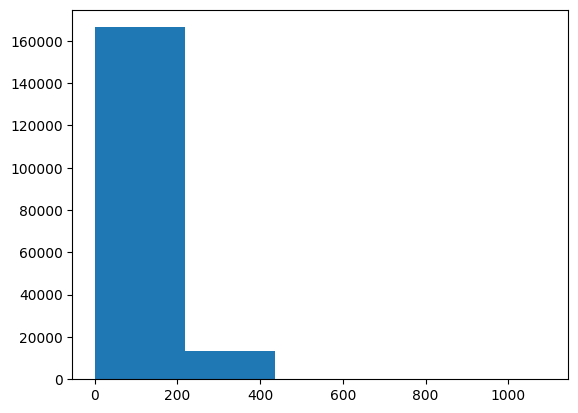

In [ ]:
#check the distribution
import matplotlib.pyplot as plt
plt.hist([len(sentence.split()) for sentence in train_char], bins=5);

In [ ]:
#find the character lenght that covers 95%
output_sequence_length_char = int(np.percentile([len(sentence.split()) for sentence in train_char], 95))
output_sequence_length_char

239

In [ ]:
# Get all keyboard characters
import string
alphabet = string.ascii_lowercase + string.digits + string.punctuation
print(alphabet)

# Create char-level token vectorizer instance
NUM_CHAR_TOKENS = len(alphabet)

abcdefghijklmnopqrstuvwxyz0123456789!"#$%&'()*+,-./:;<=>?@[\]^_`{|}~


In [ ]:
NUM_CHAR_TOKENS

68

In [ ]:
char_vectorizer = TextVectorization(
    max_tokens=NUM_CHAR_TOKENS,
    output_mode='int',
    output_sequence_length=280,  # Adjust based on your needs
    standardize='lower_and_strip_punctuation'
)

# Adapt the vectorizer to your text data
char_vectorizer.adapt(train_char)  # Assuming train_texts is your list of training texts

In [ ]:
# check character vocab stats
char_vocab = char_vectorizer.get_vocabulary()
print(f"Number of characters in vocab: {len(char_vocab)}")
print(f"5 characters in vocab: {char_vocab[:5]}")
print(f'5 least used characters in vocab: {char_vocab[-5:]}')


Number of characters in vocab: 28
5 characters in vocab: ['', '[UNK]', 'e', 't', 'i']
5 least used characters in vocab: ['k', 'x', 'z', 'q', 'j']


In [ ]:
#Test out character vectorizer
random_sentence = random.choice(train_char)
print(f"Original text:\n{random_sentence}\
      \n\nVectorized version:")
print(f'{char_vectorizer(random_sentence)}')
print(f'Lenght of the sentence: {len(random_sentence.split())}')

Original text:
s p e c i m e n s   t r e a t e d   w i t h   t h e   s n - c o n t a i n i n g   n a f   d e n t i f r i c e   s h o w e d   @   m   o f   s u r f a c e   l o s s   @   (   s e m   )   ,   w h i c h   w a s   n o t   s i g n i f i c a n t l y   d i f f e r e n t   (   p   <   @   ,   f i s h e r   l s d   )   f r o m   t h a t   o f   a   c l i n i c a l l y   p r o v e n   ,   s t a b i l i s e d   s n f @   p o s i t i v e   c o n t r o l   - l s b -   c r e s t   (   )   p r o - h e a l t h   ,   @ , @   p p m   f   a s   s n f @   :   @   m   o f   s u r f a c e   l o s s   @   (   s e m   )   - r s b -   .      

Vectorized version:
[ 9 14  2 11  4 15  2  6  9  3  8  2  5  3  2 10 20  4  3 13  3 13  2  9
  6 11  7  6  3  5  4  6  4  6 18  6  5 17 10  2  6  3  4 17  8  4 11  2
  9 13  7 20  2 10 15  7 17  9 16  8 17  5 11  2 12  7  9  9  9  2 15 20
 13  4 11 13 20  5  9  6  7  3  9  4 18  6  4 17  4 11  5  6  3 12 19 10
  4 17 17  2  8  2  6  3 14 17  4  9 13  2  8 

## Create a character level embedding

In [ ]:
#create a char layer embedding
char_embedding = layers.Embedding(input_dim=NUM_CHAR_TOKENS,
                                  output_dim=25, #size of the dim in the  paper
                                  mask_zero=True,
                                  name='char_embedding')

In [ ]:
#test out the char embedding layer
random_sentence = random.choice(train_char)
print(f"Original text:\n{random_sentence}\
      \n\nVectorized version:")
print(f'{char_embedding(char_vectorizer(random_sentence))}')
print(f'char embedding shape: {char_embedding(char_vectorizer(random_sentence)).shape}')

Original text:
r a n d o m i s a t i o n   w a s   d o n e   c e n t r a l l y   w i t h   a n   i n t e r a c t i v e   v o i c e   r e s p o n s e   s y s t e m   ;   p a t i e n t s   a n d   s t u d y   i n v e s t i g a t o r s   w e r e   m a s k e d   t o   t r e a t m e n t   d u r a t i o n   u p   t o   w e e k   @   b u t   n o t   t o   t r e a t m e n t   a l l o c a t i o n   .      

Vectorized version:
[[ 0.04225773  0.00060961  0.04849453 ...  0.026303    0.02764389
  -0.00457017]
 [ 0.04584609 -0.04099407  0.03983307 ... -0.0470899   0.00796922
  -0.00699   ]
 [ 0.02742646 -0.04688941  0.02590741 ... -0.04996351  0.00974075
  -0.02316978]
 ...
 [ 0.03565137 -0.0418239   0.04836014 ... -0.00485082  0.04553146
   0.04733611]
 [ 0.03565137 -0.0418239   0.04836014 ... -0.00485082  0.04553146
   0.04733611]
 [ 0.03565137 -0.0418239   0.04836014 ... -0.00485082  0.04553146
   0.04733611]]
char embedding shape: (280, 25)


In [ ]:
#building embedding Conv1D with the charcter level tokenizer
inputs = layers.Input(shape=(1,), dtype='string')
x = text_vectorizer(inputs)
x = char_embedding(x)
x = layers.Conv1D(64, kernel_size=5, padding='same', activation='relu')(x)
x = layers.GlobalAveragePooling1D()(x)
outputs = layers.Dense(num_classes, activation='softmax')(x)
model_3 = tf.keras.Model(inputs, outputs, name='model_3_char_embedding')

/usr/local/lib/python3.10/dist-packages/keras/src/layers/layer.py:915: UserWarning: Layer 'conv1d_1' (of type Conv1D) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


In [ ]:
#Compile the model
model_3.compile(loss='sparse_categorical_crossentropy',
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['accuracy'])

In [ ]:
model_3.summary()

Model: "model_3_char_embedding"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)           │ (None, 1)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ text_vectorization                   │ (None, 55)                  │               0 │
│ (TextVectorization)                  │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ char_embedding (Embedding)           │ (None, 55, 25)              │           1,700 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_1 (Conv1D)                    │ (None, 55, 64)              │           8,064 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling1d_1           │ (None, 64)                  │               0 │
│ (GlobalAveragePooling1D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 5)                   │             325 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 10,089 (39.41 KB)

 Trainable params: 10,089 (39.41 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
#Create a char level data set
train_char_dataset = tf.data.Dataset.from_tensor_slices((tf.constant(train_char), train_labels_encoded)).batch(32).prefetch(tf.data.AUTOTUNE)
valid_char_dataset = tf.data.Dataset.from_tensor_slices((tf.constant(val_char), val_labels_encoded)).batch(32).prefetch(tf.data.AUTOTUNE)
test_char_dataset = tf.data.Dataset.from_tensor_slices((tf.constant(test_char), test_labels_encoded)).batch(32).prefetch(tf.data.AUTOTUNE)

In [ ]:
train_char_dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>

In [ ]:
# Get all keyboard characters
alphabet = string.ascii_lowercase + string.digits + string.punctuation
print(alphabet)

# Create char-level token vectorizer instance
NUM_CHAR_TOKENS = len(alphabet) + 2  # +2 for padding and OOV (out of vocabulary) tokens
char_vectorizer = TextVectorization(
    max_tokens=NUM_CHAR_TOKENS,
    output_mode='int',
    output_sequence_length=280,  # Adjust based on your needs
    standardize='lower_and_strip_punctuation'
)

# Adapt the vectorizer to your text data
char_vectorizer.adapt(train_sentences)  # Assuming train_texts is your list of training texts

# Create an embedding layer
char_embedding = layers.Embedding(input_dim=NUM_CHAR_TOKENS, output_dim=128, mask_zero=True)

# Building the model
inputs = layers.Input(shape=[], dtype='string')
x = char_vectorizer(inputs)
x = char_embedding(x)
x = layers.Conv1D(25, kernel_size=5, padding='same', activation='relu')(x)
x = layers.GlobalAveragePooling1D()(x)
outputs = layers.Dense(num_classes, activation='softmax')(x)
model_3 = tf.keras.Model(inputs, outputs, name='model_3_char_embedding')

# Compile the model
model_3.compile(loss='sparse_categorical_crossentropy',
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['accuracy'])

# Ensure train and validation datasets are properly created
train_dataset = tf.data.Dataset.from_tensor_slices((train_sentences, train_labels_encoded)).batch(32)
val_dataset = tf.data.Dataset.from_tensor_slices((val_sentences, val_labels_encoded)).batch(32)

# Fit the model
history_3 = model_3.fit(train_dataset,
                        steps_per_epoch=int(0.1 * len(train_dataset)),
                        epochs=3,
                        validation_data=val_dataset,
                        validation_steps=int(0.1 * len(val_dataset)))

abcdefghijklmnopqrstuvwxyz0123456789!"#$%&'()*+,-./:;<=>?@[\]^_`{|}~


/usr/local/lib/python3.10/dist-packages/keras/src/layers/layer.py:915: UserWarning: Layer 'conv1d_3' (of type Conv1D) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


Epoch 1/3
562/562 ━━━━━━━━━━━━━━━━━━━━ 10s 15ms/step - accuracy: 0.3929 - loss: 1.4017 - val_accuracy: 0.5436 - val_loss: 1.1122
Epoch 2/3
562/562 ━━━━━━━━━━━━━━━━━━━━ 8s 14ms/step - accuracy: 0.5584 - loss: 1.0694 - val_accuracy: 0.5901 - val_loss: 0.9901
Epoch 3/3
562/562 ━━━━━━━━━━━━━━━━━━━━ 8s 15ms/step - accuracy: 0.5936 - loss: 0.9941 - val_accuracy: 0.5994 - val_loss: 0.9856


In [ ]:
#evaluate the model
model_3.evaluate(val_dataset)

945/945 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.6028 - loss: 0.9715


[0.968582034111023, 0.6048589944839478]

In [ ]:
#make predictions
model_3_pred_probs = model_3.predict(valid_char_dataset)

945/945 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step


In [ ]:
model_3_preds = tf.argmax(model_3_pred_probs, axis=1)
model_3_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([2, 2, 2, ..., 4, 4, 4])>

In [ ]:
model_3_results = calculate_results(y_true=val_labels_encoded,
                                    y_pred=model_3_preds)
model_3_results

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


{'accuracy': 35.9228121276314,
 'precision': 0.26380681200475264,
 'recall': 0.35922812127631404,
 'f1': 0.2838276257172179}

In [ ]:
base_line_results

{'accuracy': 72.1832384482987,
 'precision': 0.7186466952323352,
 'recall': 0.7218323844829869,
 'f1': 0.6989250353450294}

## MODEl_4: create a character embedding using a pre trained model

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers
import tensorflow_hub as hub

# Custom layer to wrap the Universal Sentence Encoder
class UniversalSentenceEncoderLayer(layers.Layer):
    def __init__(self, **kwargs):
        super(UniversalSentenceEncoderLayer, self).__init__(**kwargs)
        self.use_layer = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder/4", trainable=False)

    def call(self, inputs):
        return self.use_layer(inputs)

In [ ]:
# Token model
token_inputs = layers.Input(shape=[], dtype=tf.string, name="token_input")
token_embeddings = UniversalSentenceEncoderLayer()(token_inputs)
token_outputs = layers.Dense(128, activation="relu")(token_embeddings)
token_model = tf.keras.Model(inputs=token_inputs, outputs=token_outputs)

In [ ]:
# Char model
char_inputs = layers.Input(shape=(1,), dtype=tf.string, name="char_input")
char_vectors = char_vectorizer(char_inputs)
char_embeddings = layers.Embedding(input_dim=NUM_CHAR_TOKENS, output_dim=128, mask_zero=True)(char_vectors)
char_bi_lstm = layers.Bidirectional(layers.LSTM(24))(char_embeddings)
char_model = tf.keras.Model(inputs=char_inputs, outputs=char_bi_lstm)

In [ ]:
# Concatenate token and char inputs (create hybrid token and char embedding model)
combined_embeddings = layers.Concatenate(name="token_char_hybrid_embedding")([token_model.output, char_model.output])

# Add dropout layers as shown in the provided screenshot
combined_dropout = layers.Dropout(0.5)(combined_embeddings)
combined_dense = layers.Dense(128, activation="relu")(combined_dropout)
final_dropout = layers.Dropout(0.5)(combined_dense)
output_layer = layers.Dense(num_classes, activation="softmax")(final_dropout)

In [ ]:
# Final hybrid model
model_4 = tf.keras.Model(inputs=[token_inputs, char_inputs], outputs=output_layer)

# Compile the model
model_4.compile(loss='sparse_categorical_crossentropy',
                     optimizer=tf.keras.optimizers.SGD(),
                     metrics=['accuracy'])

# Ensure train and validation datasets are properly created
train_dataset = tf.data.Dataset.from_tensor_slices(({"token_input": train_sentences, "char_input": train_sentences}, train_labels_encoded)).batch(32)
val_dataset = tf.data.Dataset.from_tensor_slices(({"token_input": val_sentences, "char_input": val_sentences}, val_labels_encoded)).batch(32)

# Train the hybrid model
history_model_4 = model_4.fit(train_dataset,
                                  steps_per_epoch=int(0.1 * len(train_dataset)),
                                  epochs=3,
                                  validation_data=val_dataset,
                                  validation_steps=int(0.1 * len(val_dataset)))

Epoch 1/3
562/562 ━━━━━━━━━━━━━━━━━━━━ 96s 162ms/step - accuracy: 0.3255 - loss: 1.5338 - val_accuracy: 0.3893 - val_loss: 1.4498
Epoch 2/3
562/562 ━━━━━━━━━━━━━━━━━━━━ 90s 160ms/step - accuracy: 0.3911 - loss: 1.4473 - val_accuracy: 0.5153 - val_loss: 1.3911
Epoch 3/3
562/562 ━━━━━━━━━━━━━━━━━━━━ 91s 162ms/step - accuracy: 0.4340 - loss: 1.4098 - val_accuracy: 0.5256 - val_loss: 1.3319


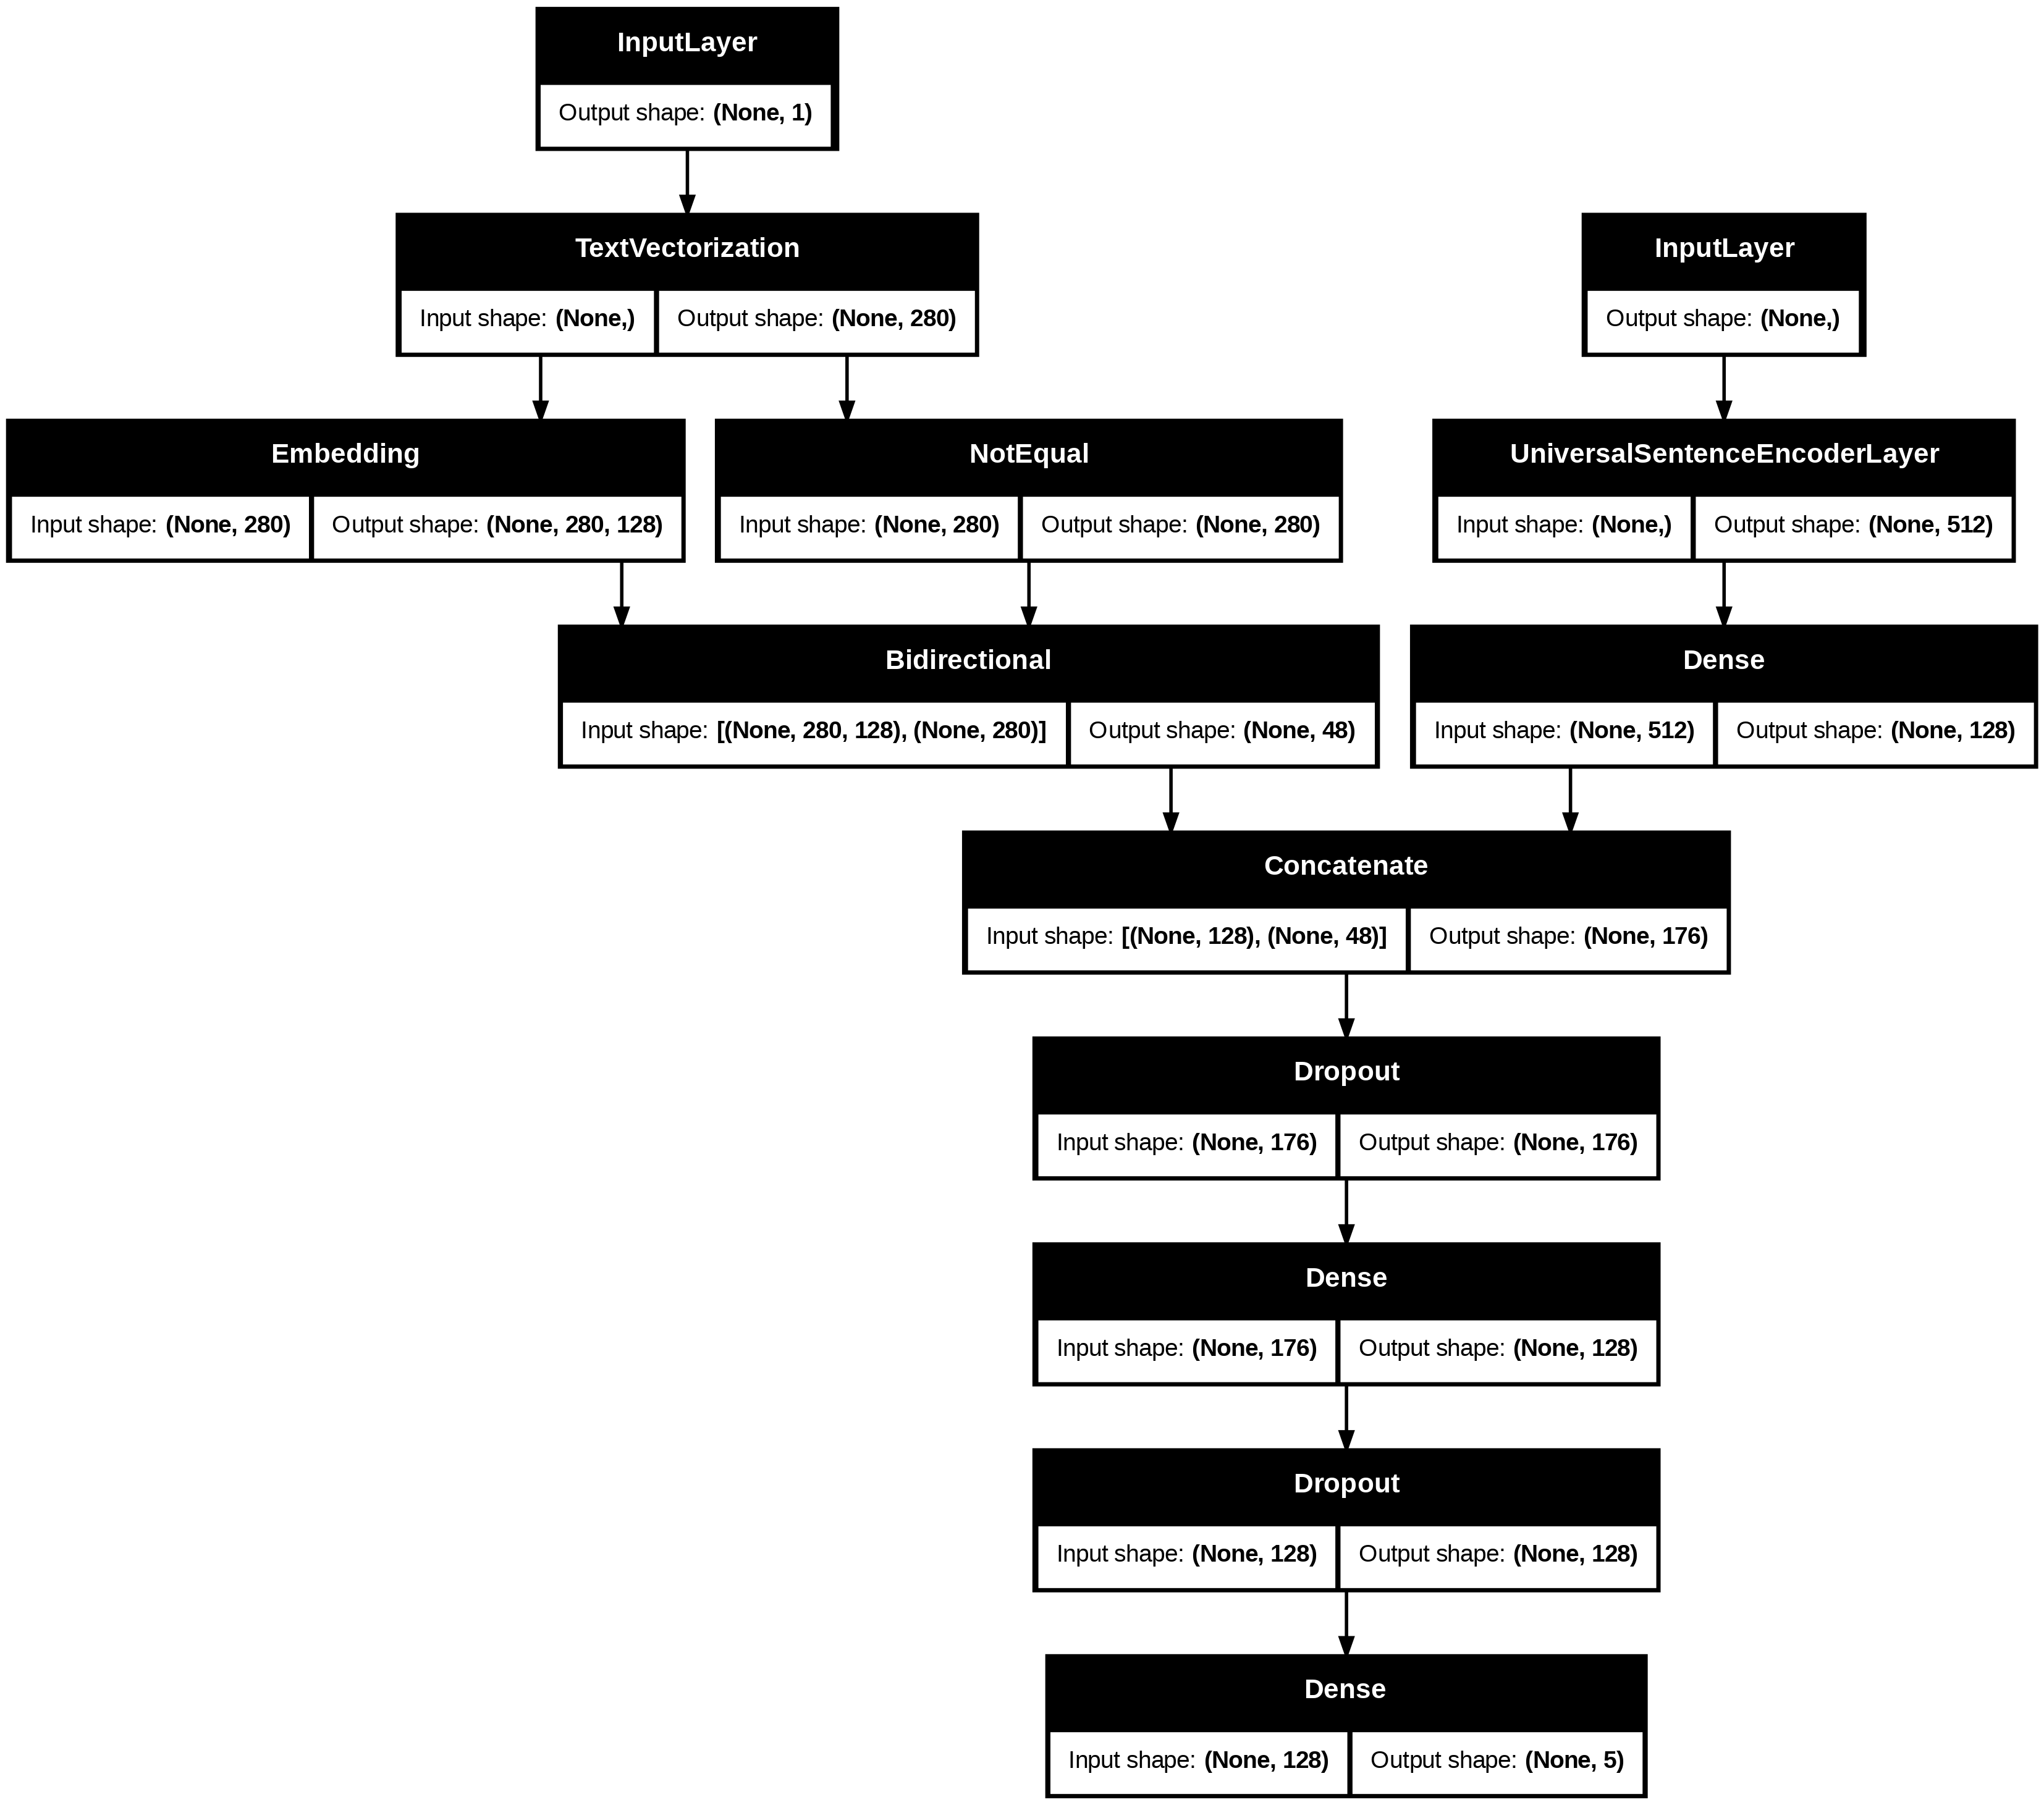

In [ ]:
from keras.utils import plot_model
plot_model(model_4, show_shapes=True)

In [ ]:
#evaluate the model
model_4.evaluate(val_dataset)

945/945 ━━━━━━━━━━━━━━━━━━━━ 28s 30ms/step - accuracy: 0.5192 - loss: 1.3274


[1.3270984888076782, 0.5225076079368591]

In [ ]:
model_4_pred_probs = model_4.predict(val_dataset)

945/945 ━━━━━━━━━━━━━━━━━━━━ 29s 30ms/step


In [ ]:
model_4_preds = tf.argmax(model_4_pred_probs, axis=1)
model_4_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([4, 4, 2, ..., 4, 4, 2])>

In [ ]:
model_4_results = calculate_results(y_true=val_labels_encoded,
                                    y_pred=model_4_preds)
model_4_results

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


{'accuracy': 52.25076128690587,
 'precision': 0.34697787793983753,
 'recall': 0.5225076128690587,
 'f1': 0.41528887387777913}

In [ ]:
model_1_results

{'accuracy': 78.26779492284719,
 'precision': 0.7797450876029411,
 'recall': 0.7826779492284719,
 'f1': 0.7806585253513543}

## MODEL_5

**Hybrid Model for Text Classification**

This notebook demonstrates how to build a hybrid text classification model using TensorFlow and Keras. The model integrates multiple input features including pretrained token embeddings from the Universal Sentence Encoder, character-level embeddings, and a custom feature representing the total number of lines in each input text.

Key Features:

	1.	Pretrained Token Embeddings:
	•	Utilizes the Universal Sentence Encoder from TensorFlow Hub to obtain high-quality token-level embeddings.
	2.	Character-Level Embeddings:
	•	Implements a TextVectorization layer to vectorize characters.
	•	Uses an Embedding layer to convert these vectors into dense embeddings.
	•	Processes the character embeddings through a Bidirectional LSTM layer to capture sequential information.
	3.	Total Lines Feature:
	•	Includes a custom feature representing the total number of lines in each input text.
	•	One-hot encodes this feature for integration into the model.


In [ ]:
# One-hot encode the total_lines feature
train_total_lines_one_hot = tf.one_hot(train_df["total_lines"].to_numpy(), depth=20)
val_total_lines_one_hot = tf.one_hot(val_df["total_lines"].to_numpy(), depth=20)

In [ ]:
EMBEDDING_DIM = 128

# Token inputs
token_inputs = layers.Input(shape=[], dtype="string", name="token_inputs")
token_embeddings = UniversalSentenceEncoderLayer()(token_inputs)
token_outputs = layers.Dense(128, activation="relu")(token_embeddings)
token_model = tf.keras.Model(inputs=token_inputs, outputs=token_outputs)

# Char inputs
char_inputs = layers.Input(shape=(1,), dtype="string", name="char_inputs")
char_vectors = char_vectorizer(char_inputs)
char_embeddings = layers.Embedding(input_dim=NUM_CHAR_TOKENS, output_dim=EMBEDDING_DIM, mask_zero=True)(char_vectors)

char_bi_lstm = layers.Bidirectional(layers.LSTM(24))(char_embeddings)
char_model = tf.keras.Model(inputs=char_inputs, outputs=char_bi_lstm)

# Total lines inputs
total_lines_input = layers.Input(shape=(20,), name="total_lines_input")
total_lines_dense = layers.Dense(32, activation="relu")(total_lines_input)
total_lines_model = tf.keras.Model(inputs=total_lines_input, outputs=total_lines_dense)

# Concatenate token, char, and total lines inputs
combined_embeddings = layers.Concatenate(name="token_char_hybrid_embedding")([token_model.output, char_model.output, total_lines_model.output])

# Add dropout layers as shown in the provided screenshot
combined_dropout = layers.Dropout(0.5)(combined_embeddings)
combined_dense = layers.Dense(128, activation="relu")(combined_dropout)
final_dropout = layers.Dropout(0.5)(combined_dense)
output_layer = layers.Dense(num_classes, activation="softmax")(final_dropout)

# Final hybrid model
hybrid_model = tf.keras.Model(inputs=[token_inputs, char_inputs, total_lines_input], outputs=output_layer)

# Compile the model
hybrid_model.compile(loss='sparse_categorical_crossentropy',
                     optimizer=tf.keras.optimizers.Adam(),
                     metrics=['accuracy'])

# Ensure train and validation datasets are properly created
train_dataset = tf.data.Dataset.from_tensor_slices(({"token_inputs": train_sentences, "char_inputs": train_sentences, "total_lines_input": train_total_lines_one_hot}, train_labels_encoded)).batch(32)
val_dataset = tf.data.Dataset.from_tensor_slices(({"token_inputs": val_sentences, "char_inputs": val_sentences, "total_lines_input": val_total_lines_one_hot}, val_labels_encoded)).batch(32)

# Train the hybrid model
history_hybrid = hybrid_model.fit(train_dataset,
                                  steps_per_epoch=int(0.1 * len(train_dataset)),
                                  epochs=3,
                                  validation_data=val_dataset,
                                  validation_steps=int(0.1 * len(val_dataset)))

Epoch 1/3
562/562 ━━━━━━━━━━━━━━━━━━━━ 99s 164ms/step - accuracy: 0.5211 - loss: 1.1415 - val_accuracy: 0.7224 - val_loss: 0.7217
Epoch 2/3
562/562 ━━━━━━━━━━━━━━━━━━━━ 90s 160ms/step - accuracy: 0.7117 - loss: 0.7610 - val_accuracy: 0.7410 - val_loss: 0.6626
Epoch 3/3
562/562 ━━━━━━━━━━━━━━━━━━━━ 92s 164ms/step - accuracy: 0.7241 - loss: 0.7207 - val_accuracy: 0.7563 - val_loss: 0.6534


In [ ]:
hybrid_model.summary()

Model: "functional_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ char_inputs (InputLayer)  │ (None, 1)              │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ token_inputs (InputLayer) │ (None)                 │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ text_vectorization_3      │ (None, 280)            │              0 │ char_inputs[0][0]      │
│ (TextVectorization)       │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ universal_sentence_encod… │ (None, 512)            │              0 │ token_inputs[0][0]     │
│ (UniversalSentenceEncode… │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding_6 (Embedding)   │ (None, 280, 128)       │          8,960 │ text_vectorization_3[… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ not_equal_10 (NotEqual)   │ (None, 280)            │              0 │ text_vectorization_3[… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ total_lines_input         │ (None, 20)             │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_18 (Dense)          │ (None, 128)            │         65,664 │ universal_sentence_en… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bidirectional_1           │ (None, 48)             │         29,376 │ embedding_6[0][0],     │
│ (Bidirectional)           │                        │                │ not_equal_10[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_19 (Dense)          │ (None, 32)             │            672 │ total_lines_input[0][… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ token_char_hybrid_embedd… │ (None, 208)            │              0 │ dense_18[0][0],        │
│ (Concatenate)             │                        │                │ bidirectional_1[0][0], │
│                           │                        │                │ dense_19[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_2 (Dropout)       │ (None, 208)            │              0 │ token_char_hybrid_emb… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_20 (Dense)          │ (None, 128)            │         26,752 │ dropout_2[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_3 (Dropout)       │ (None, 128)            │              0 │ dense_20[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_21 (Dense)          │ (None, 5)              │            645 │ dropout_3[0][0]        │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 396,209 (1.51 MB)

 Trainable params: 132,069 (515.89 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 264,140 (1.01 MB)

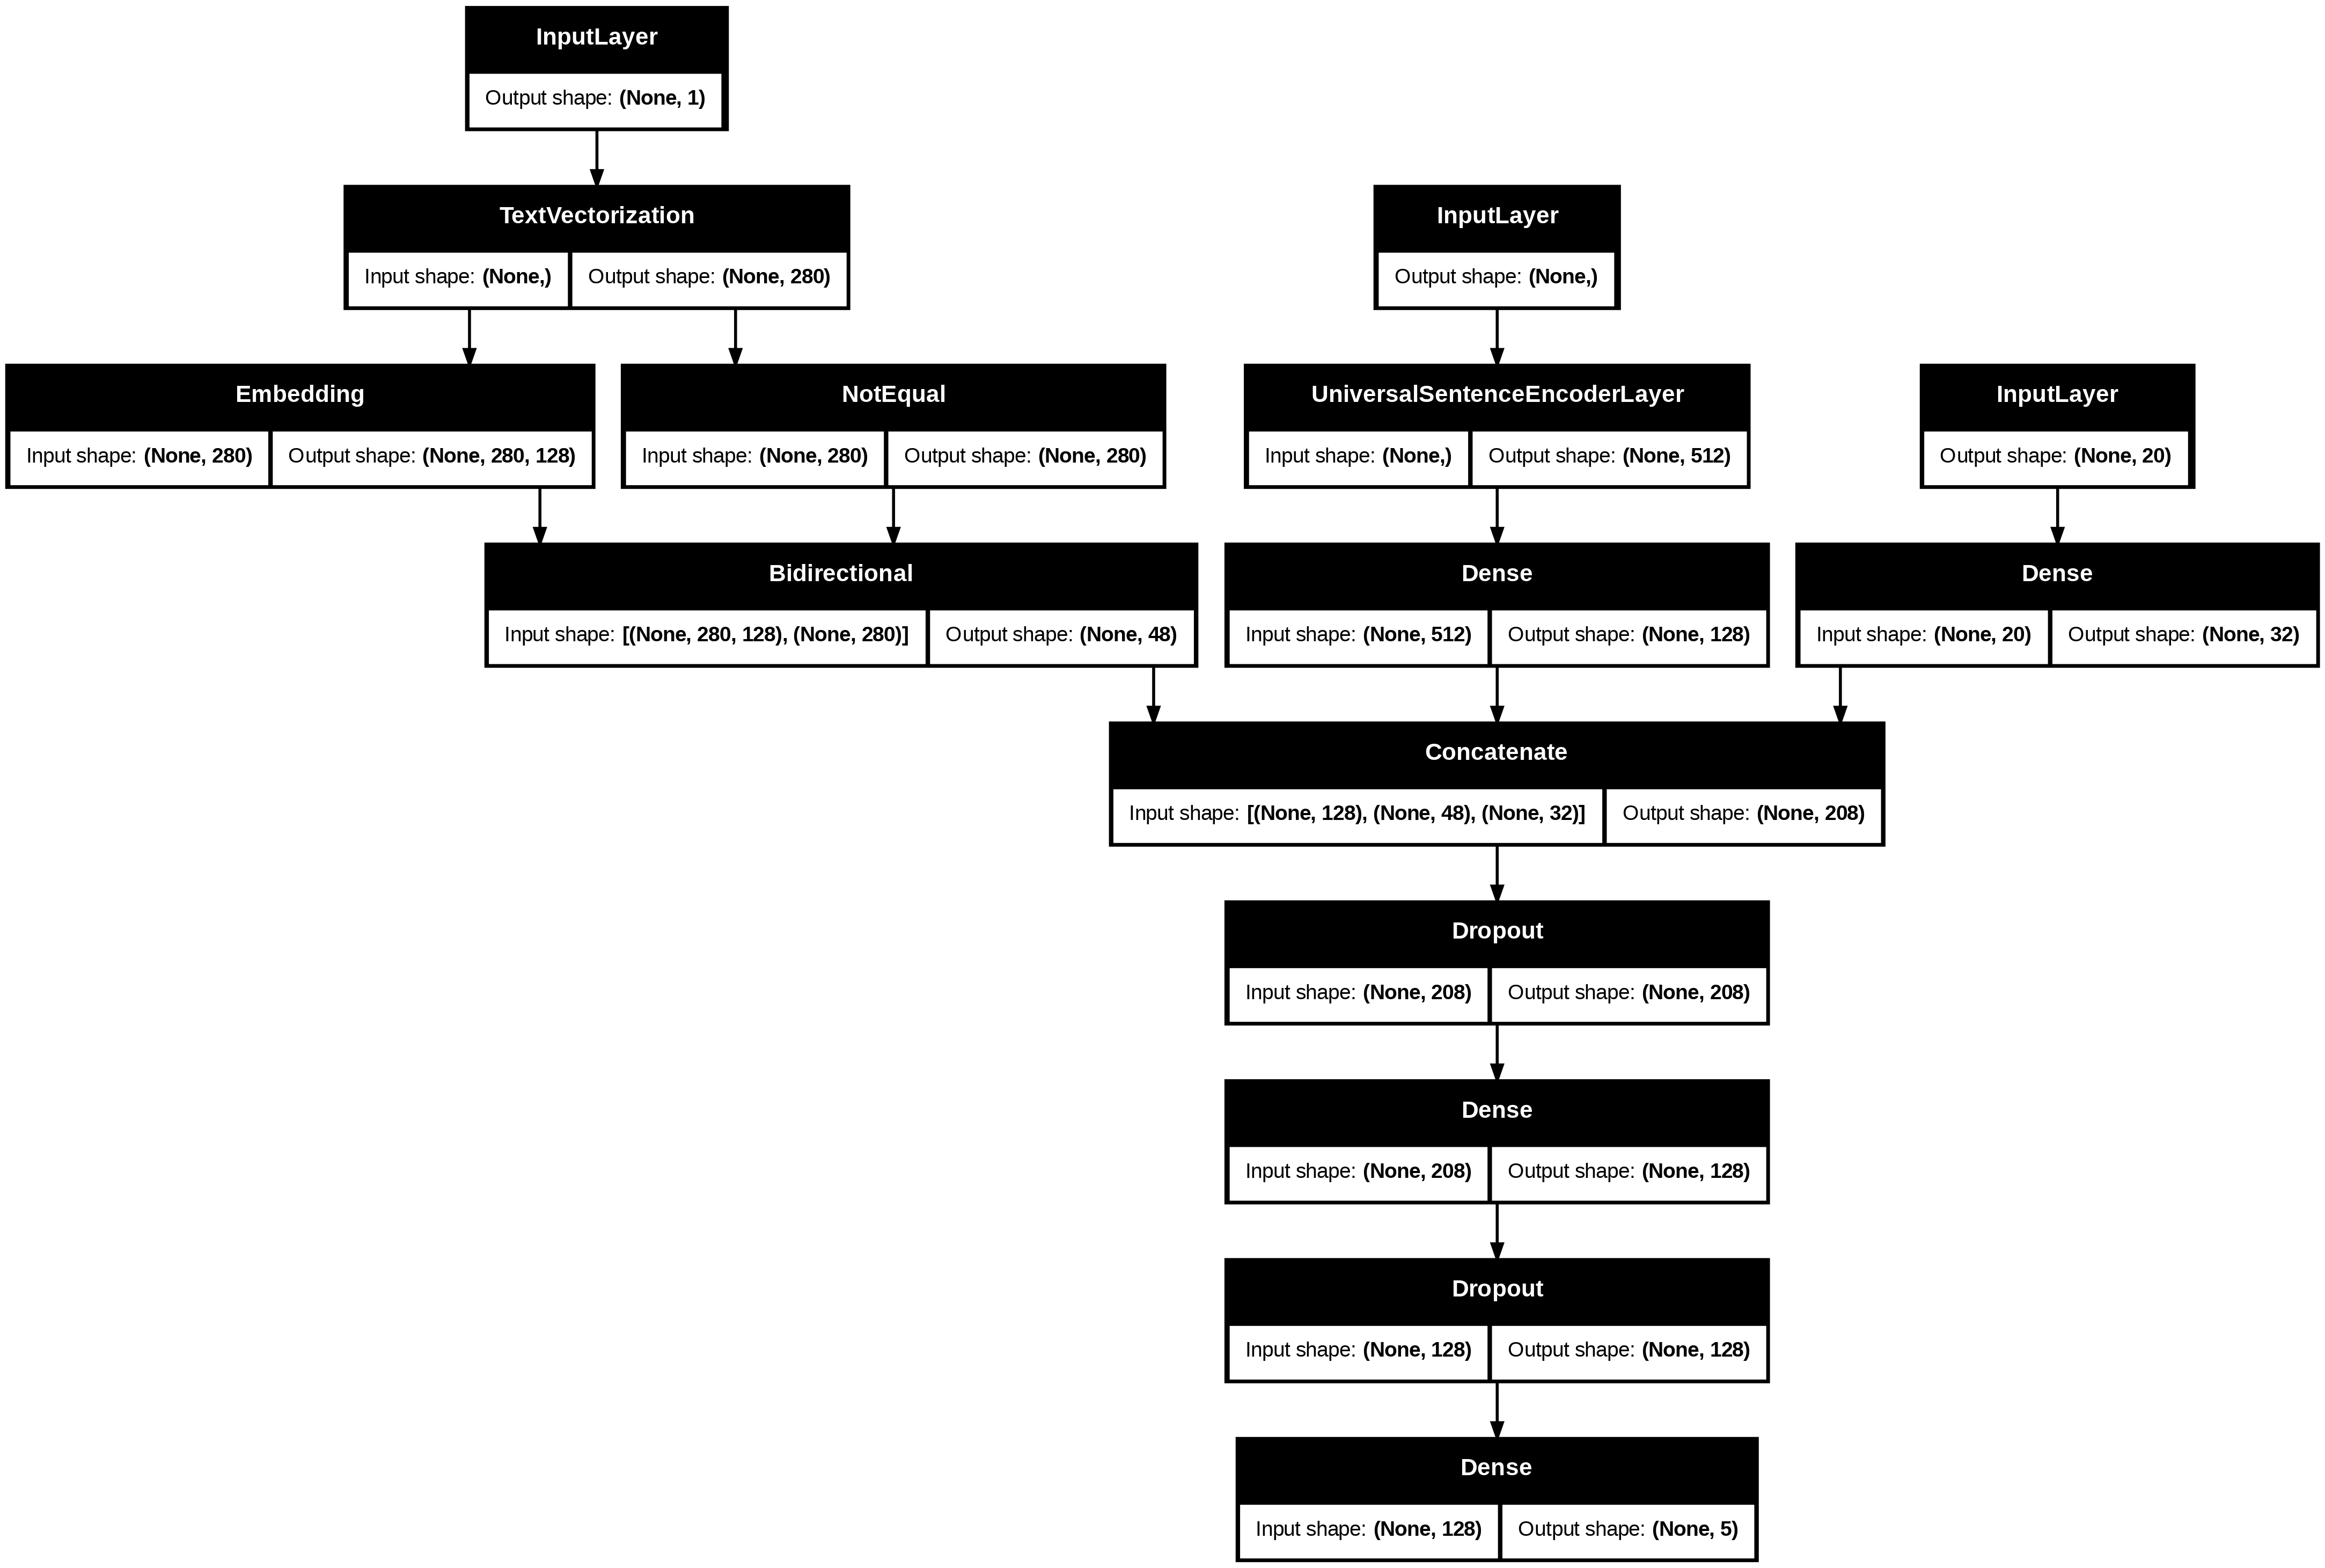

In [ ]:
#plot the model
from keras.utils import plot_model
plot_model(hybrid_model, show_shapes=True)

In [ ]:
hybrid_model.evaluate(val_dataset)

945/945 ━━━━━━━━━━━━━━━━━━━━ 30s 32ms/step - accuracy: 0.7516 - loss: 0.6522


[0.6520987153053284, 0.7518866658210754]

In [ ]:
hybrid_model_pred_probs = hybrid_model.predict(val_dataset)

945/945 ━━━━━━━━━━━━━━━━━━━━ 30s 32ms/step


In [ ]:
hybrid_model_preds = tf.argmax(hybrid_model_pred_probs, axis=1)

In [ ]:
hybrid_model_results = calculate_results(y_true=val_labels_encoded,
                                    y_pred=hybrid_model_preds)
hybrid_model_results

{'accuracy': 75.18866675493182,
 'precision': 0.75343811406076,
 'recall': 0.7518866675493181,
 'f1': 0.7513997965201374}